In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
df = pd.read_csv('201901-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,1989.0,Male,No
1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,1989.0,Male,No
2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,1965.0,Female,No
3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,1974.0,Male,No
4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,NaN,NaN,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192082 entries, 0 to 192081
Data columns (total 16 columns):
duration_sec               192082 non-null int64
start_time                 192082 non-null object
end_time                   192082 non-null object
start_station_id           191834 non-null float64
start_station_name         191834 non-null object
start_station_latitude     192082 non-null float64
start_station_longitude    192082 non-null float64
end_station_id             191834 non-null float64
end_station_name           191834 non-null object
end_station_latitude       192082 non-null float64
end_station_longitude      192082 non-null float64
bike_id                    192082 non-null int64
user_type                  192082 non-null object
member_birth_year          182362 non-null float64
member_gender              182365 non-null object
bike_share_for_all_trip    192082 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 23.4+ MB


In [4]:
df = df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182122 entries, 0 to 192081
Data columns (total 16 columns):
duration_sec               182122 non-null int64
start_time                 182122 non-null object
end_time                   182122 non-null object
start_station_id           182122 non-null float64
start_station_name         182122 non-null object
start_station_latitude     182122 non-null float64
start_station_longitude    182122 non-null float64
end_station_id             182122 non-null float64
end_station_name           182122 non-null object
end_station_latitude       182122 non-null float64
end_station_longitude      182122 non-null float64
bike_id                    182122 non-null int64
user_type                  182122 non-null object
member_birth_year          182122 non-null float64
member_gender              182122 non-null object
bike_share_for_all_trip    182122 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 23.6+ MB


In [5]:
x1 = len(df['start_station_id'].unique())
x2 = len(df[['start_station_id', 'start_station_name']].drop_duplicates())
x3 = len(df[['start_station_id', 'start_station_latitude']].drop_duplicates())
x4 = len(df[['start_station_id', 'start_station_longitude']].drop_duplicates())

y1 = len(df['end_station_id'].unique())
y2 = len(df[['end_station_id', 'end_station_name']].drop_duplicates())
y3 = len(df[['end_station_id', 'end_station_latitude']].drop_duplicates())
y4 = len(df[['end_station_id', 'end_station_longitude']].drop_duplicates())


print(x1)
print(x2)
print(x3)
print(x4)
print('____')
print(y1)
print(y2)
print(y3)
print(y4)

324
324
324
324
____
324
324
324
324


In [6]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,1989.0,Male,No
1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,1989.0,Male,No
2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,1965.0,Female,No
3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,1974.0,Male,No
5,6733,2019-01-31 22:35:50.8130,2019-02-01 00:28:04.5120,245.0,Downtown Berkeley BART,37.870139,-122.268422,266.0,Parker St at Fulton St,37.862464,-122.264791,3532,Subscriber,1994.0,Male,No


In [7]:
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S')
df['end_time'] =pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182122 entries, 0 to 192081
Data columns (total 16 columns):
duration_sec               182122 non-null int64
start_time                 182122 non-null datetime64[ns]
end_time                   182122 non-null datetime64[ns]
start_station_id           182122 non-null float64
start_station_name         182122 non-null object
start_station_latitude     182122 non-null float64
start_station_longitude    182122 non-null float64
end_station_id             182122 non-null float64
end_station_name           182122 non-null object
end_station_latitude       182122 non-null float64
end_station_longitude      182122 non-null float64
bike_id                    182122 non-null int64
user_type                  182122 non-null object
member_birth_year          182122 non-null float64
member_gender              182122 non-null object
bike_share_for_all_trip    182122 non-null object
dtypes: datetime64[ns](2), float64(7), int64(2), object(5)
memory us

In [8]:
start = df[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = df[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

df_loc = pd.concat([start, end]).drop_duplicates()
df_loc



,station_id,station_name,station_latitude,station_longitude
0,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915
2,245.0,Downtown Berkeley BART,37.870139,-122.268422
3,85.0,Church St at Duboce Ave,37.770083,-122.429156
6,34.0,Father Alfred E Boeddeker Park,37.783988,-122.412408
7,318.0,San Carlos St at Market St,37.330698,-121.888979
8,29.0,O'Farrell St at Divisadero St,37.782405,-122.439446
9,223.0,16th St Mission BART Station 2,37.764765,-122.420091
11,266.0,Parker St at Fulton St,37.862464,-122.264791
12,349.0,Howard St at Mary St,37.781010,-122.405666


In [9]:


def gen_time_segment(dt):
    if dt.minute < 30:
        minute = "%02d" % 0
    else:
        minute = "%02d" % 30
    return "{}-{}-{} {}:{}".format(dt.year, dt.month, dt.day, dt.hour, minute)

df['start_seg'] = [gen_time_segment(dt) for dt in df['start_time']]
df['stop_seg'] = [gen_time_segment(dt) for dt in df['end_time']]

df[['start_station_id', 'start_time', 'start_seg', 'end_station_id', 'end_time', 'stop_seg']]

,start_station_id,start_time,start_seg,end_station_id,end_time,stop_seg
0,229.0,2019-01-31 17:57:44.613,2019-1-31 17:30,196.0,2019-02-01 16:24:49.864,2019-2-1 16:00
1,4.0,2019-01-31 20:58:33.886,2019-1-31 20:30,134.0,2019-02-01 15:16:54.173,2019-2-1 15:00
2,245.0,2019-01-31 18:06:52.924,2019-1-31 18:00,157.0,2019-02-01 11:30:46.530,2019-2-1 11:30
3,85.0,2019-01-31 19:46:09.719,2019-1-31 19:30,53.0,2019-02-01 08:10:50.318,2019-2-1 8:00
5,245.0,2019-01-31 22:35:50.813,2019-1-31 22:30,266.0,2019-02-01 00:28:04.512,2019-2-1 0:00
6,34.0,2019-01-31 23:54:38.901,2019-1-31 23:30,146.0,2019-02-01 00:14:27.900,2019-2-1 0:00
7,318.0,2019-01-31 23:48:50.092,2019-1-31 23:30,314.0,2019-02-01 00:09:44.497,2019-2-1 0:00
8,29.0,2019-01-31 23:17:05.462,2019-1-31 23:00,70.0,2019-02-01 00:09:39.457,2019-2-1 0:00
9,223.0,2019-01-31 23:59:47.568,2019-1-31 23:30,129.0,2019-02-01 00:05:11.177,2019-2-1 0:00
11,266.0,2019-01-31 23:57:04.381,2019-1-31 23:30,256.0,2019-02-01 00:04:17.489,2019-2-1 0:00


In [10]:
df = df.sort_values(by='start_time',ascending=True)
df[['start_station_id', 'start_time', 'start_seg', 'end_station_id', 'end_time', 'stop_seg']]

,start_station_id,start_time,start_seg,end_station_id,end_time,stop_seg
192081,245.0,2019-01-01 00:07:10.576,2019-1-1 0:00,247.0,2019-01-01 00:10:57.196,2019-1-1 0:00
192053,16.0,2019-01-01 00:08:39.659,2019-1-1 0:00,115.0,2019-01-01 00:38:06.848,2019-1-1 0:30
192080,269.0,2019-01-01 00:09:56.211,2019-1-1 0:00,240.0,2019-01-01 00:12:58.748,2019-1-1 0:00
192079,269.0,2019-01-01 00:11:03.441,2019-1-1 0:00,243.0,2019-01-01 00:20:29.268,2019-1-1 0:00
192075,163.0,2019-01-01 00:14:48.398,2019-1-1 0:00,159.0,2019-01-01 00:26:38.421,2019-1-1 0:00
192076,23.0,2019-01-01 00:14:55.921,2019-1-1 0:00,91.0,2019-01-01 00:25:02.215,2019-1-1 0:00
192035,21.0,2019-01-01 00:15:11.324,2019-1-1 0:00,44.0,2019-01-01 00:47:09.221,2019-1-1 0:30
192034,21.0,2019-01-01 00:15:26.529,2019-1-1 0:00,44.0,2019-01-01 00:47:19.626,2019-1-1 0:30
192077,109.0,2019-01-01 00:16:36.845,2019-1-1 0:00,141.0,2019-01-01 00:23:07.253,2019-1-1 0:00
192070,23.0,2019-01-01 00:16:58.847,2019-1-1 0:00,90.0,2019-01-01 00:30:59.993,2019-1-1 0:30


In [11]:
df['start_seg'].iloc[0]

'2019-1-1 0:00'

In [12]:
inflow = df[['end_station_id', 'stop_seg']] \
            .groupby(['end_station_id', 'stop_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'end_station_id':'station_id','stop_seg':'time', 'counts':'in_flow_count'})

outflow = df[['start_station_id', 'start_seg']] \
            .groupby(['start_station_id', 'start_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'start_station_id':'station_id','start_seg':'time', 'counts':'out_flow_count'})

In [13]:
station_id_list = list(df_loc['station_id'])
first_segment = df['start_seg'].iloc[0]
last_segment = df['start_seg'].iloc[-1]

# Create combinations of time series and station ids
time_seg_list = list(pd.date_range(first_segment, last_segment, freq="30min"))
template = pd.DataFrame(list(itertools.product(station_id_list, time_seg_list)), \
                        columns=["station_id", "time"])

# Merge in/out flow information & Add zeros to missing data according to every time segment
df_flow = pd.merge(inflow, outflow, on=['station_id', 'time'], how='outer')
df_flow['time'] = pd.to_datetime(df_flow['time'], format='%Y-%m-%d %H:%M')
df_flow = df_flow.merge(template, on=["station_id", "time"], how="right").fillna(0)
df_flow

,station_id,time,in_flow_count,out_flow_count
0,3.0,2019-01-01 10:30:00,3.0,0.0
1,3.0,2019-01-01 11:30:00,3.0,4.0
2,3.0,2019-01-01 12:00:00,5.0,2.0
3,3.0,2019-01-01 12:30:00,2.0,4.0
4,3.0,2019-01-01 13:00:00,2.0,5.0
5,3.0,2019-01-01 13:30:00,3.0,1.0
6,3.0,2019-01-01 14:00:00,4.0,2.0
7,3.0,2019-01-01 14:30:00,5.0,1.0
8,3.0,2019-01-01 15:00:00,3.0,4.0
9,3.0,2019-01-01 15:30:00,1.0,3.0


In [14]:
df_loc

,station_id,station_name,station_latitude,station_longitude
0,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915
2,245.0,Downtown Berkeley BART,37.870139,-122.268422
3,85.0,Church St at Duboce Ave,37.770083,-122.429156
6,34.0,Father Alfred E Boeddeker Park,37.783988,-122.412408
7,318.0,San Carlos St at Market St,37.330698,-121.888979
8,29.0,O'Farrell St at Divisadero St,37.782405,-122.439446
9,223.0,16th St Mission BART Station 2,37.764765,-122.420091
11,266.0,Parker St at Fulton St,37.862464,-122.264791
12,349.0,Howard St at Mary St,37.781010,-122.405666


In [15]:
df_all = pd.merge(df_loc, 
                  df_flow[(df_flow['time'].dt.month == 1) & (df_flow['time'].dt.day <= 7)] \
                         .pivot(index='station_id', columns='time').reset_index(),
                  on=['station_id'], how='left')
df_all

,station_id,station_name,station_latitude,station_longitude,"(in_flow_count, 2019-01-01 00:00:00)","(in_flow_count, 2019-01-01 00:30:00)","(in_flow_count, 2019-01-01 01:00:00)","(in_flow_count, 2019-01-01 01:30:00)","(in_flow_count, 2019-01-01 02:00:00)","(in_flow_count, 2019-01-01 02:30:00)",...,"(out_flow_count, 2019-01-07 19:00:00)","(out_flow_count, 2019-01-07 19:30:00)","(out_flow_count, 2019-01-07 20:00:00)","(out_flow_count, 2019-01-07 20:30:00)","(out_flow_count, 2019-01-07 21:00:00)","(out_flow_count, 2019-01-07 21:30:00)","(out_flow_count, 2019-01-07 22:00:00)","(out_flow_count, 2019-01-07 22:30:00)","(out_flow_count, 2019-01-07 23:00:00)","(out_flow_count, 2019-01-07 23:30:00)"
0,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,245.0,Downtown Berkeley BART,37.870139,-122.268422,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,85.0,Church St at Duboce Ave,37.770083,-122.429156,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34.0,Father Alfred E Boeddeker Park,37.783988,-122.412408,0.0,3.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,318.0,San Carlos St at Market St,37.330698,-121.888979,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,29.0,O'Farrell St at Divisadero St,37.782405,-122.439446,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,223.0,16th St Mission BART Station 2,37.764765,-122.420091,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,266.0,Parker St at Fulton St,37.862464,-122.264791,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,349.0,Howard St at Mary St,37.781010,-122.405666,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['station_latitude'])
    lon = list(stns['station_longitude'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_longitude']), list(df['station_latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

### K mean

With KMeans, all stations are clustered and their sizes are similar.

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". 

In [17]:
X = df_loc[['station_latitude', 'station_longitude']].values
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

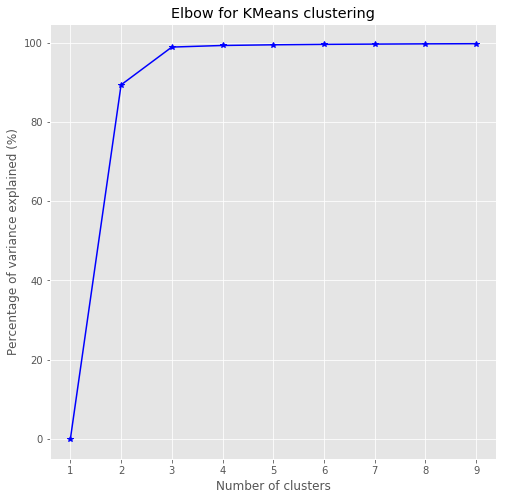

In [18]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

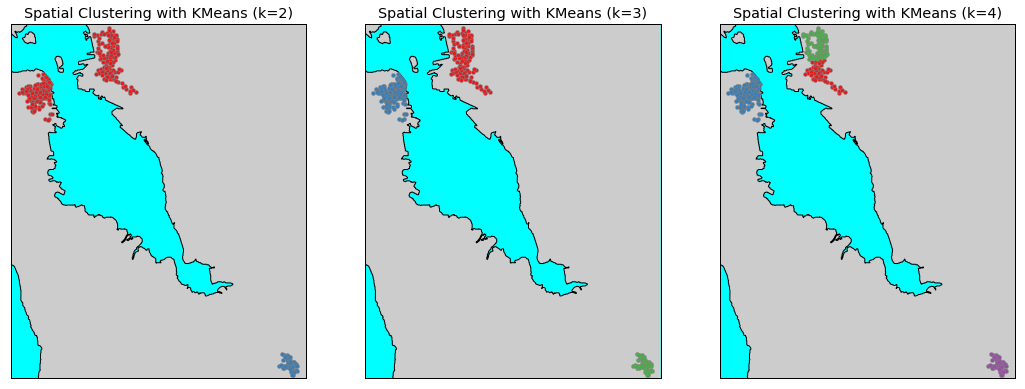

In [23]:
k = [2, 3, 4]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df_loc['cluster'] = est.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_stations_map(ax, df_loc)

### DBSCAN

Parameters:
- eps          (The maximum distance between two samples for them to be considered as in the same neighborhood)
- min_smaple   (The number of samples in a neighborhood for a point to be considered as a core point.)
- metric       (The metric to use when calculating distance between instances in a feature array.)

With DBSCAN, some stations would be missing and some clusters’ sizes are too small

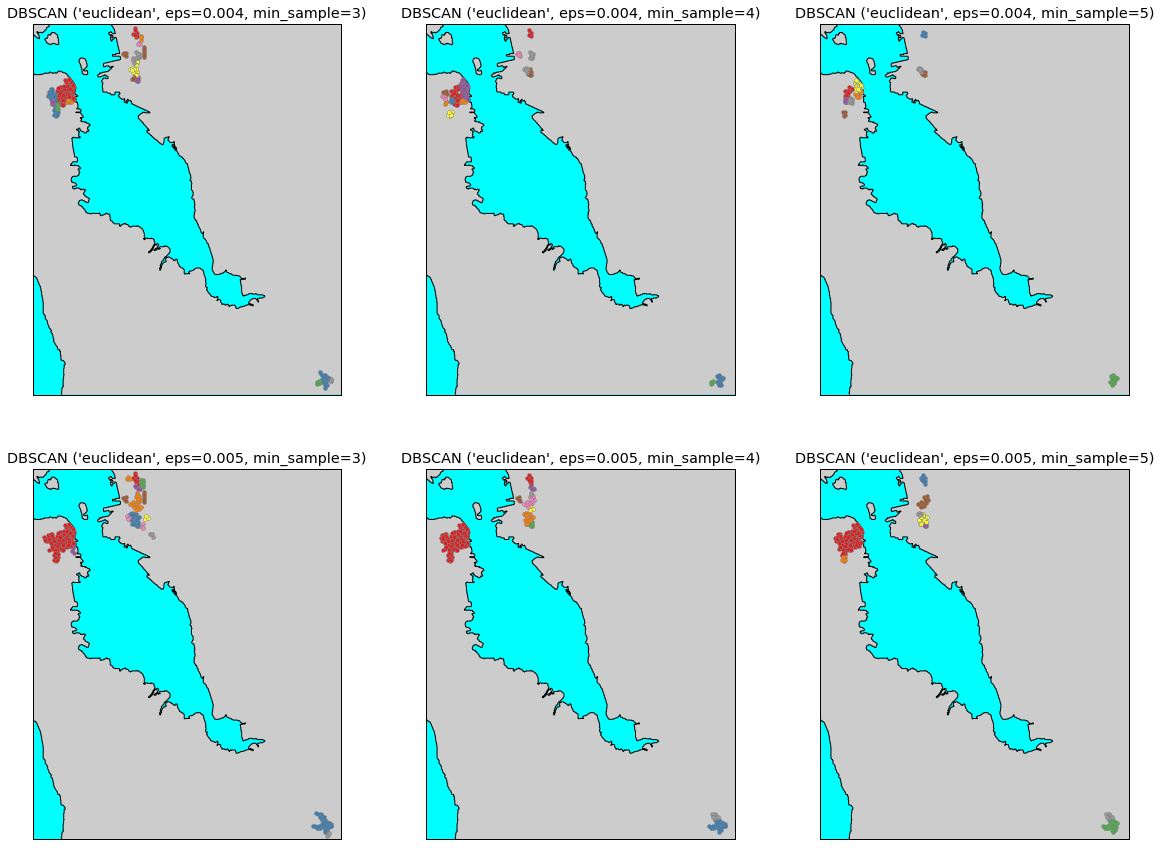

In [27]:
eps = [0.004, 0.005]   # unit: latitude/longitude
min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        df_loc['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df_loc)

## Temporal Clustering

In [28]:
X = df_all.drop(["station_id", "station_name", "station_latitude", "station_longitude"], axis=1).values

In [33]:
def plot_dendrogram(Z, p, d):
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    fancy_dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        show_contracted=True,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        annotate_above=d,  # useful in small plots so annotations don't overlap
    )
    plt.show()
    
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

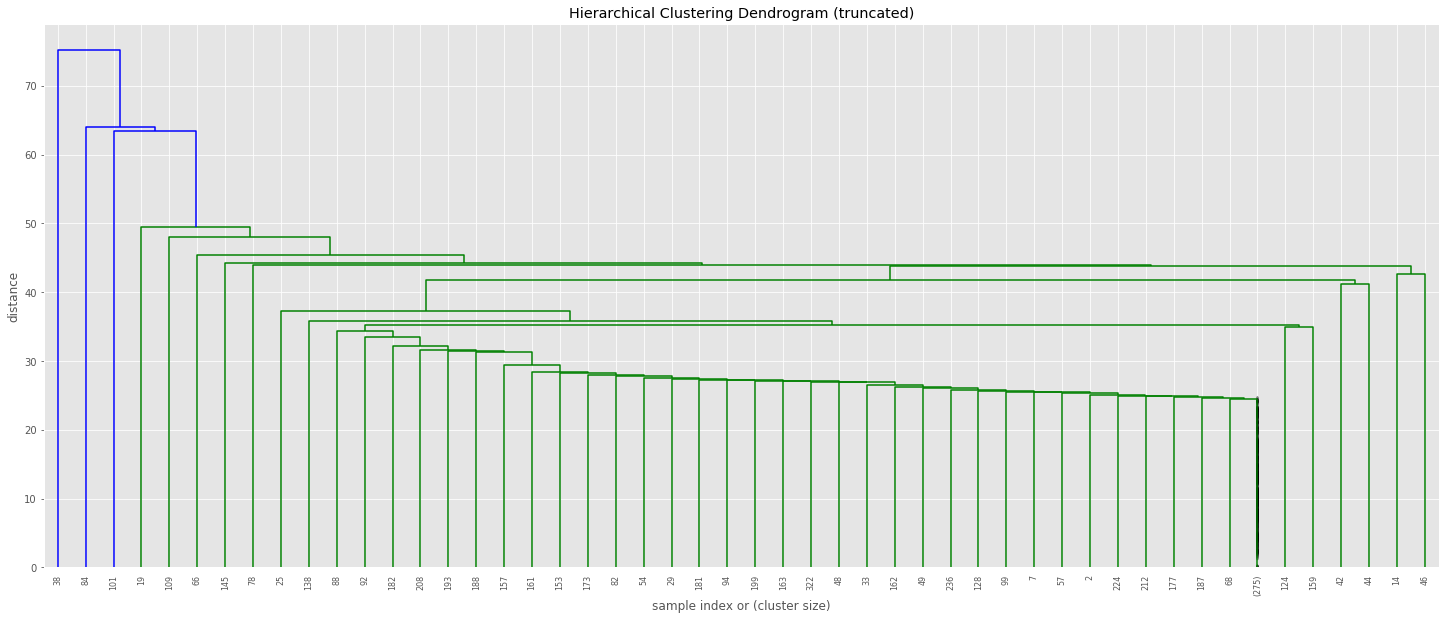

In [34]:
affinity = 'single'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                50,    # only show the last 50 merges
                125)   # only annotates distance above 125facyfa

In [37]:
def plot_agglomerative_clustering_result(df_all, Z, dist, affinity):
    n = len(dist)
    plt.subplots(nrows=n, ncols=2, figsize=(20, 18))

    for i in range(n):
        df_all['cluster'] = fcluster(Z, dist[i], 'distance')
        #k = len(df_all['cluster'].unique())
        #print("[affinity='{}', cut-off distance={}]\nNumber of clusters: {}".format(affinity, dist[i], k))

        ax = plt.subplot(n, 2, 2*i+1)
        ax.set_title("Agglomerative Clustering (affinity='{}', distance>{})".format(affinity, dist[i]))
        plot_stations_map(ax, df_all)

        ax = plt.subplot(n, 2, 2*i+2)
        ax.set_title("Average Flow for each cluster (affinity='{}', distance>{})".format(affinity, dist[i]))
        plot_flow_lines(ax, df_all)

def plot_flow_lines(ax, stns):
    clist = stns['cluster'].unique()
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, 8)))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]
        in_cols = list(filter(lambda x: 'in_flow_count' in x, df_all.columns))
        out_cols = list(filter(lambda x: 'out_flow_count' in x, df_all.columns))
        timeline = list(map(lambda x: x[1], in_cols))
        flows = df[in_cols].values + df[out_cols].values
        ax.plot(timeline, np.mean(flows, axis=0), color=color)
        #ax.plot(timeline, np.mean(flows, axis=0), color=color, alpha=0.3, linewidth=np.mean(np.std(flows, axis=0)))


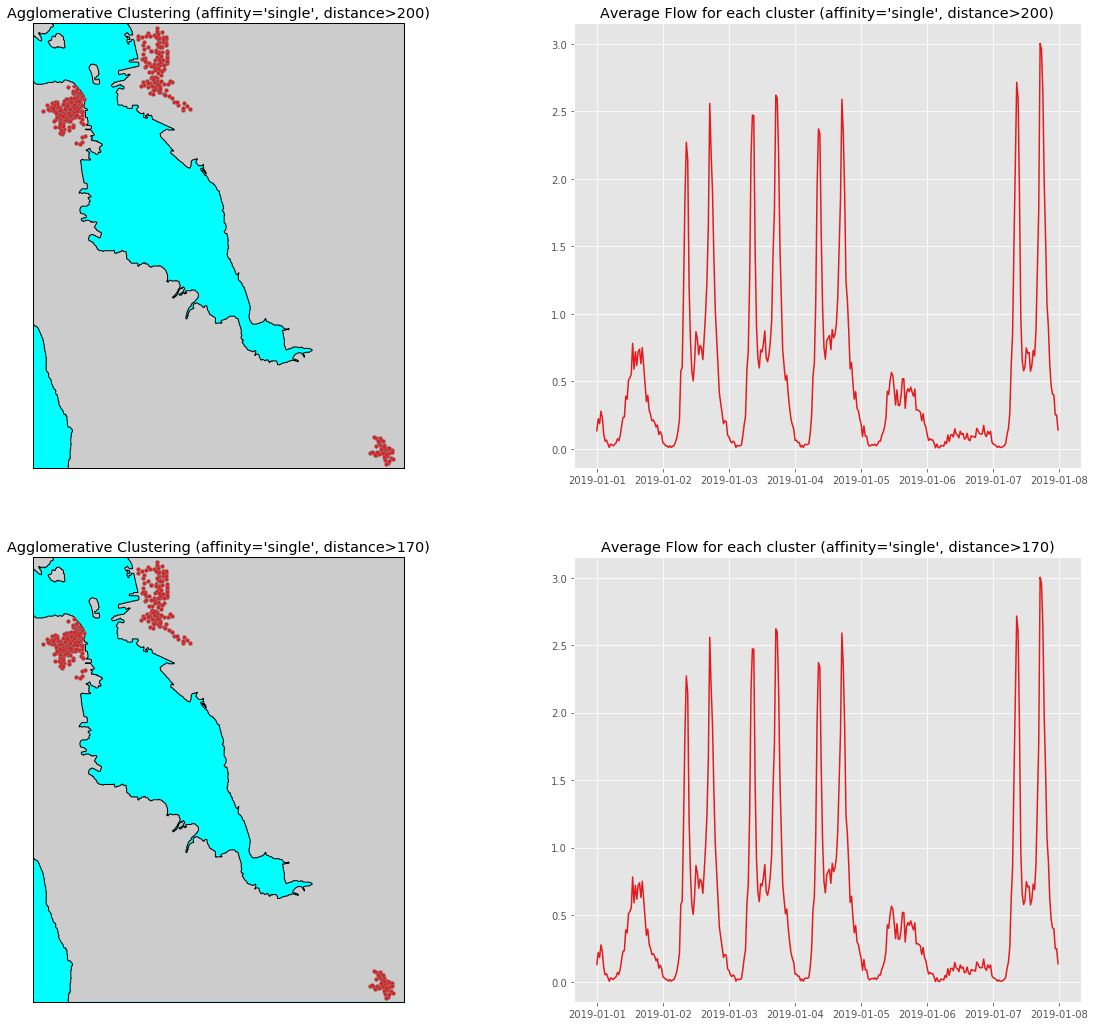

In [38]:
dist = [200, 170]
plot_agglomerative_clustering_result(df_all, Z, dist, affinity)

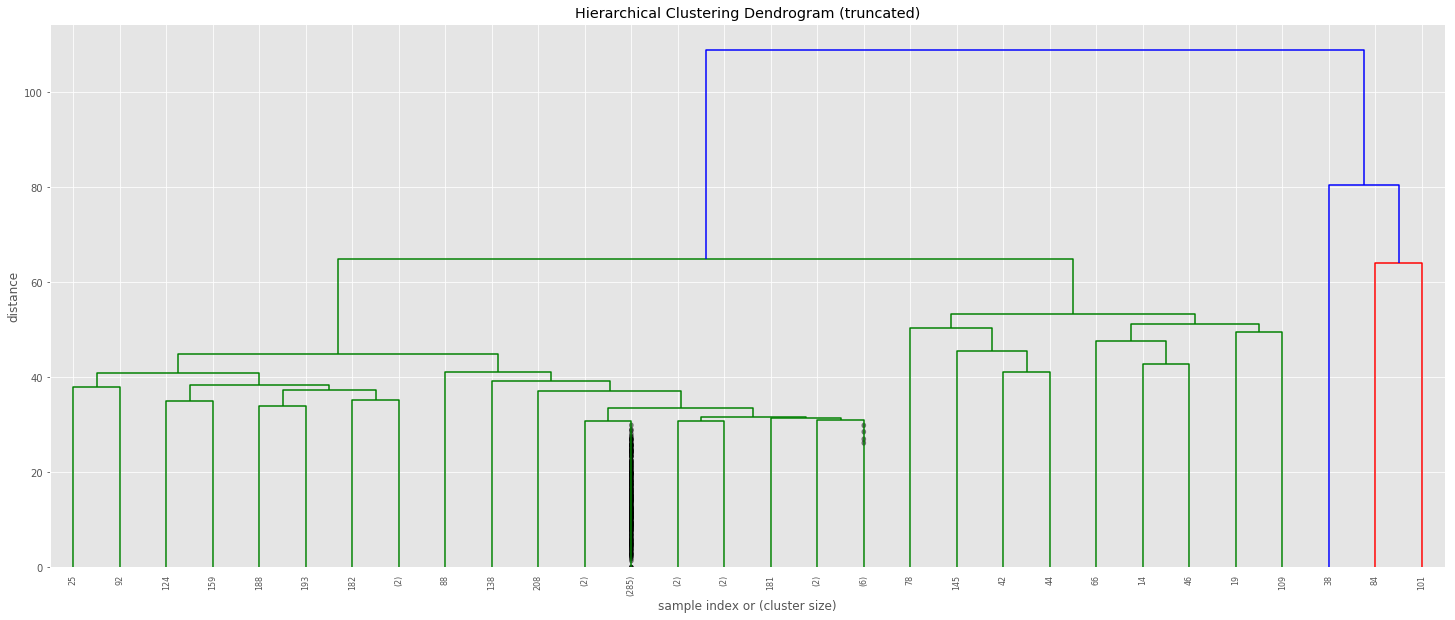

In [39]:
affinity = 'average'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                150)   # only annotates distance above 200

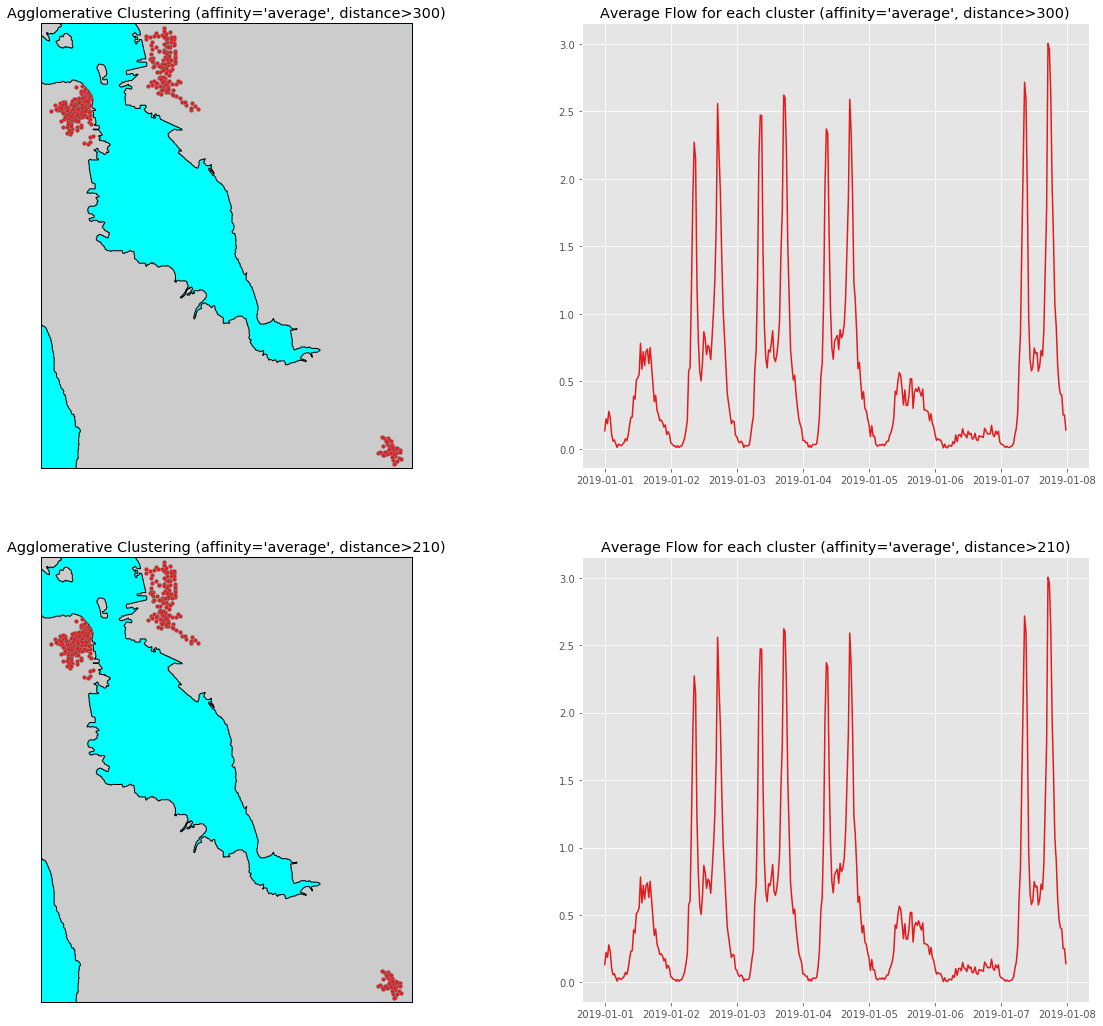

In [40]:
dist = [300, 210]
plot_agglomerative_clustering_result(df_all, Z, dist, affinity)

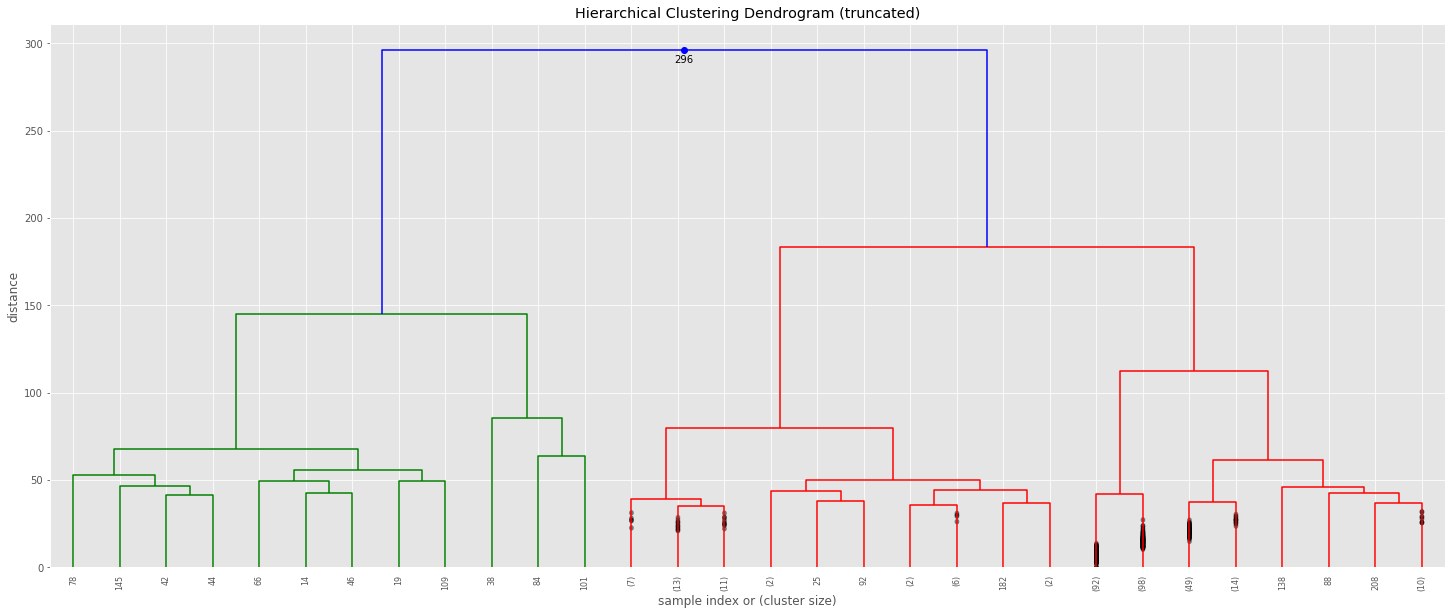

In [41]:
affinity = 'ward'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                200)   # only annotates distance above 200

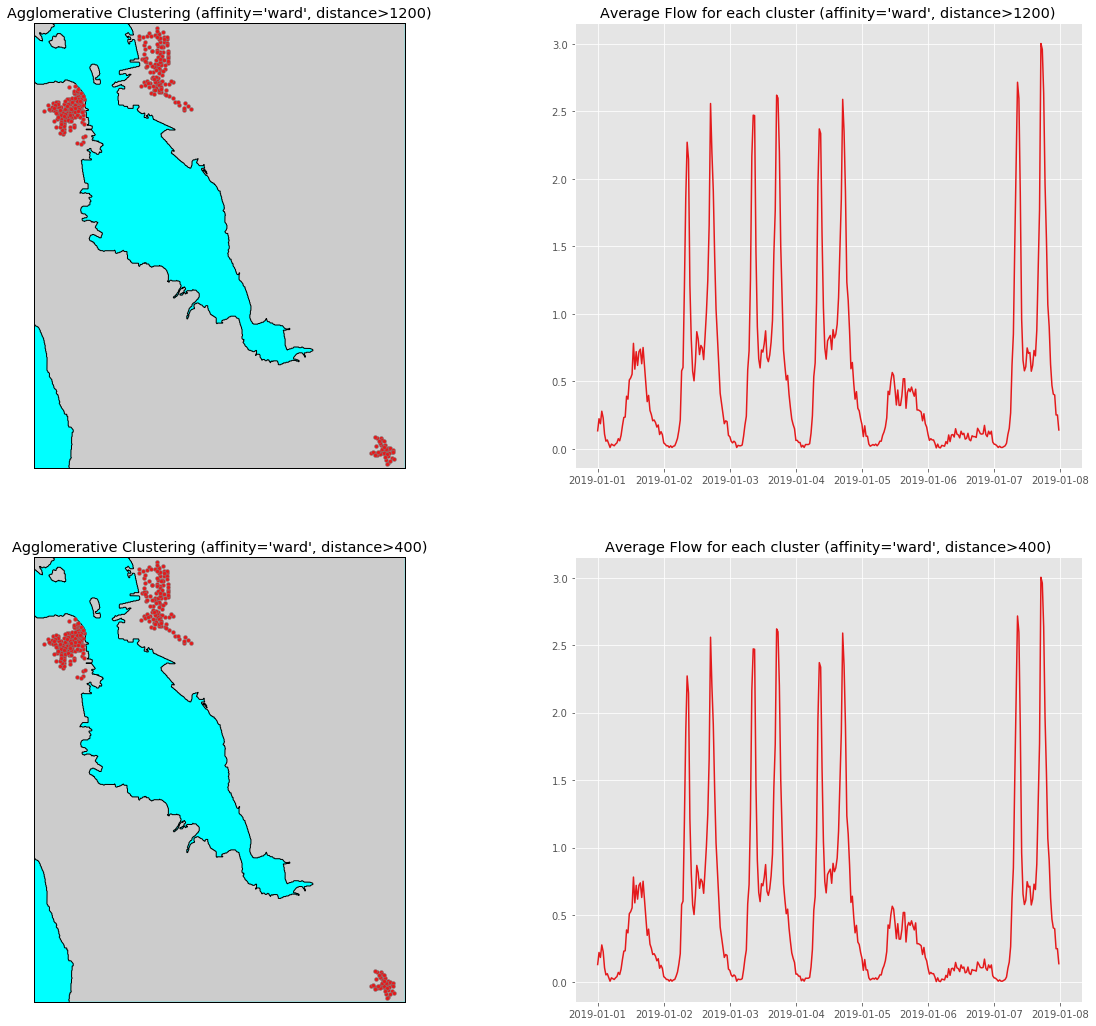

In [42]:
dist = [1200, 400]
plot_agglomerative_clustering_result(df_all, Z, dist, affinity)

### Agglomerative Clustering with PCA

In [43]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)

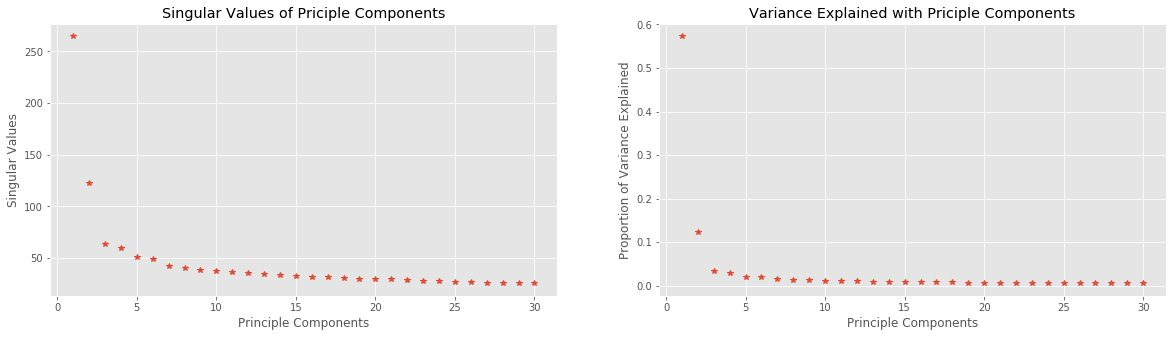

In [44]:
plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.plot(range(1, n_components+1), 
        pca.singular_values_, 
        '*')
plt.grid(True)
plt.xlabel('Principle Components')
plt.ylabel('Singular Values')
plt.title('Singular Values of Priciple Components')

ax = plt.subplot(1, 2, 2)
ax.plot(range(1, n_components+1), 
        np.power(pca.singular_values_, 2)/sum(np.power(pca.singular_values_, 2)), 
        '*')
plt.grid(True)
plt.xlabel('Principle Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Variance Explained with Priciple Components')
plt.show()

In [45]:
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)

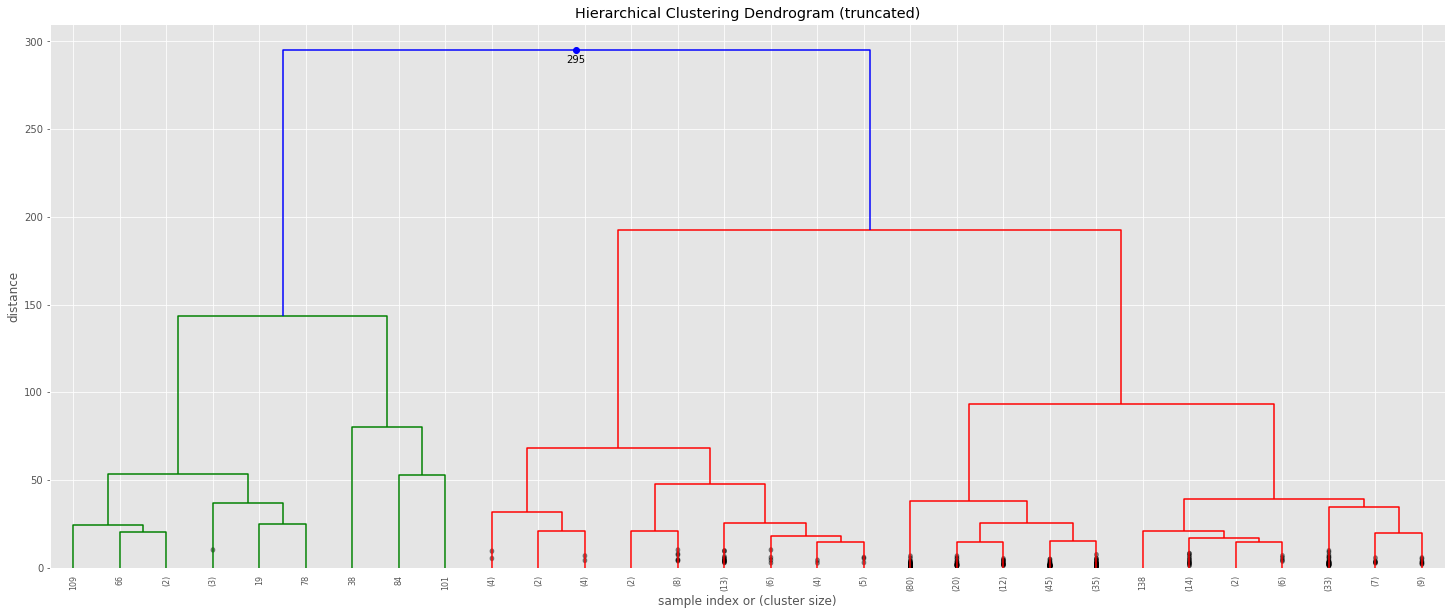

In [46]:
affinity = 'ward'
Z = linkage(X_pca, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                200)   # only annotates distance above 200

In [48]:
def plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components):
    n = len(dist)
    plt.subplots(nrows=n, ncols=2, figsize=(20, 20))

    for i in range(n):
        df_all['cluster'] = fcluster(Z, dist[i], 'distance')

        ax = plt.subplot(n, 2, 2*i+1)
        ax.set_title("Agglomerative Clustering (n_components={}, distance>{})".format(n_components, dist[i]))
        plot_stations_map(ax, df_all)

        ax = plt.subplot(n, 2, 2*i+2)
        ax.set_title("Average Flow for each cluster (n_components={}, distance>{})".format(n_components, dist[i]))
        plot_flow_lines(ax, df_all)


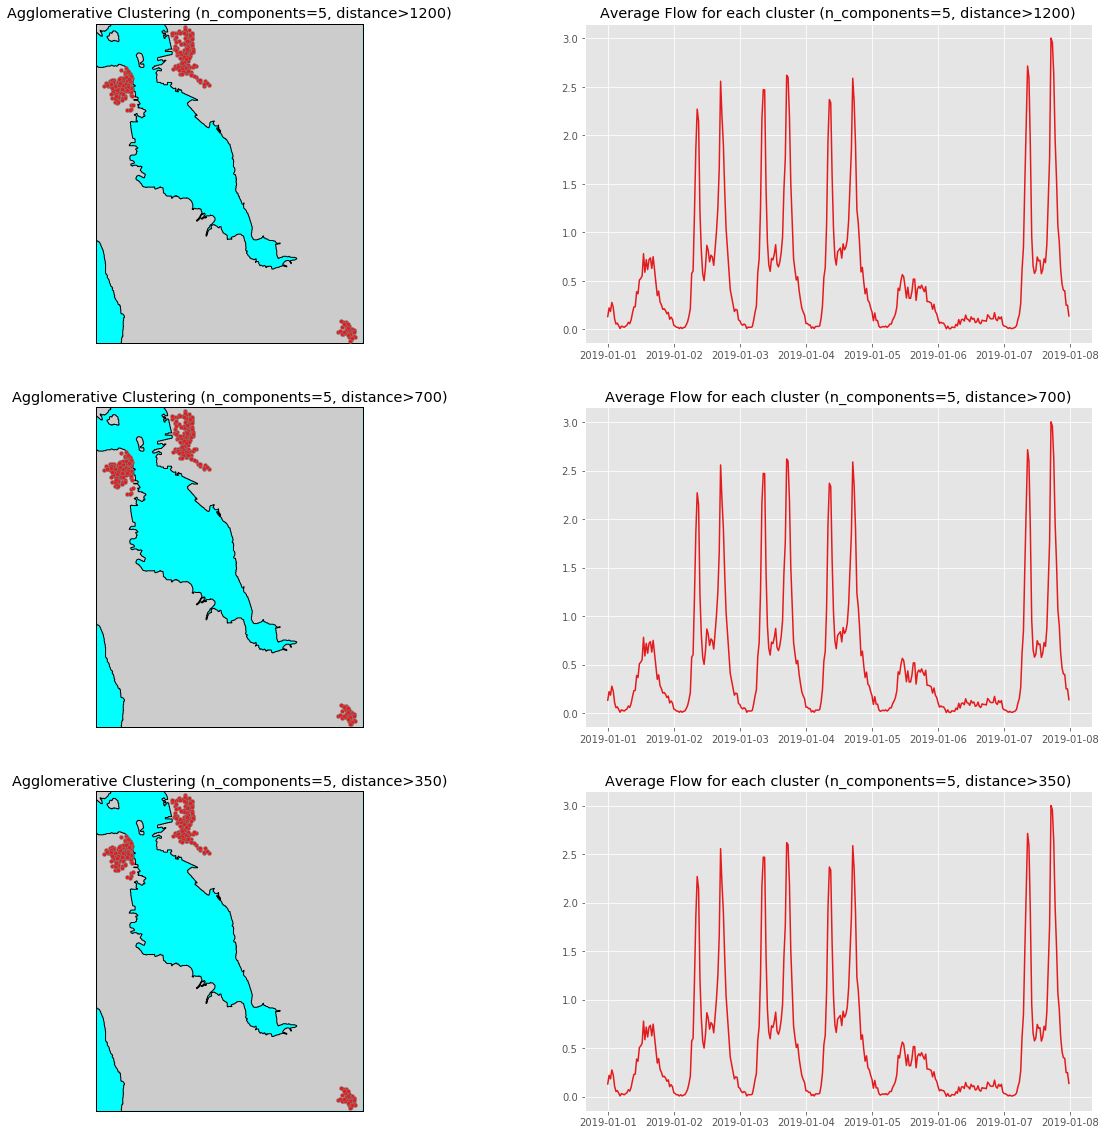

In [49]:
dist = [1200, 700, 350]
plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components)

In [51]:
n_components = 1
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)

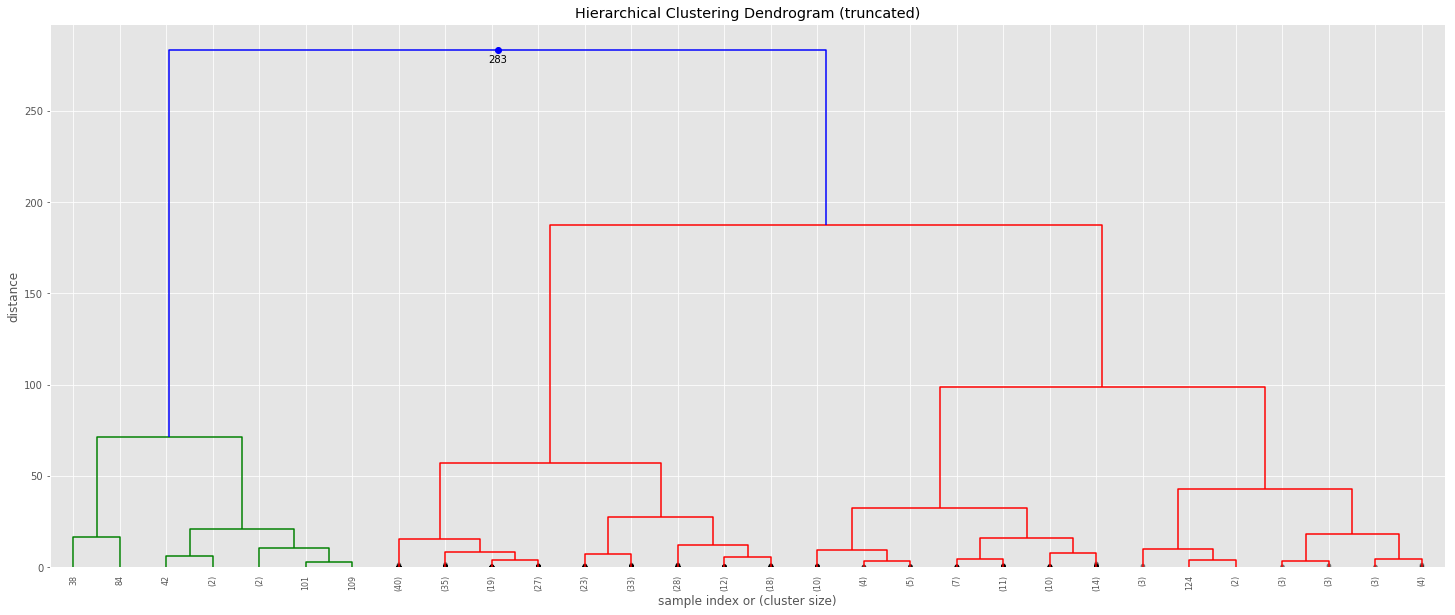

In [52]:
affinity = 'ward'
Z = linkage(X_pca, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                200)   # only annotates distance above 200

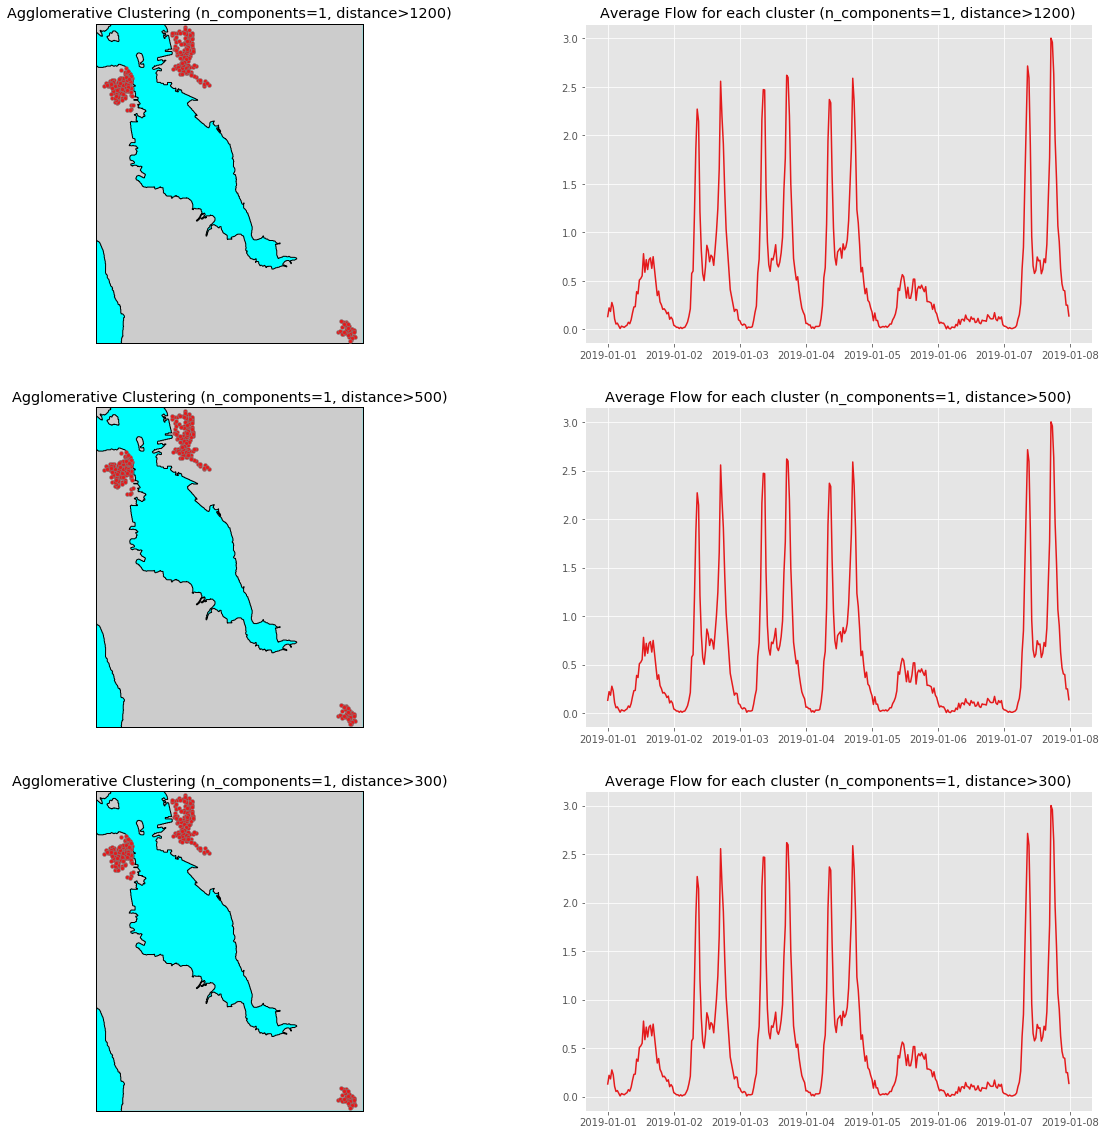

In [53]:
dist = [1200, 500, 300]
plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components)

## Spatial-Temporal Clustering

In [55]:
X = df_all.drop(["station_id", "station_name"], axis=1).values

In [56]:
def combine_spatial_temporal(X, n_temporal):
    pca = PCA(n_components=n_temporal)
    X_pca = pca.fit_transform(X[:, 2:])
    X = np.hstack((X[:, :2], X_pca))
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    return X_std

In [57]:
def plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_all):
    n = len(n_components)
    plt.subplots(nrows=n, ncols=2, figsize=(20,15))

    for i in range(n):
        est = kmean[i]
        df_all['cluster'] = est.predict(Xs[i]).tolist()

        ax = plt.subplot(n, 2, 2*i+1)
        ax.set_title("Spatial-Temporal Clustering with KMeans (#temporal features={}, k={})".format(n_components[i], k))
        plot_stations_map(ax, df_all)

        ax = plt.subplot(n, 2, 2*i+2)
        ax.set_title("Average Flow for each cluster (#temporal features={}, k={})".format(n_components[i], k))
        plot_flow_lines(ax, df_all)

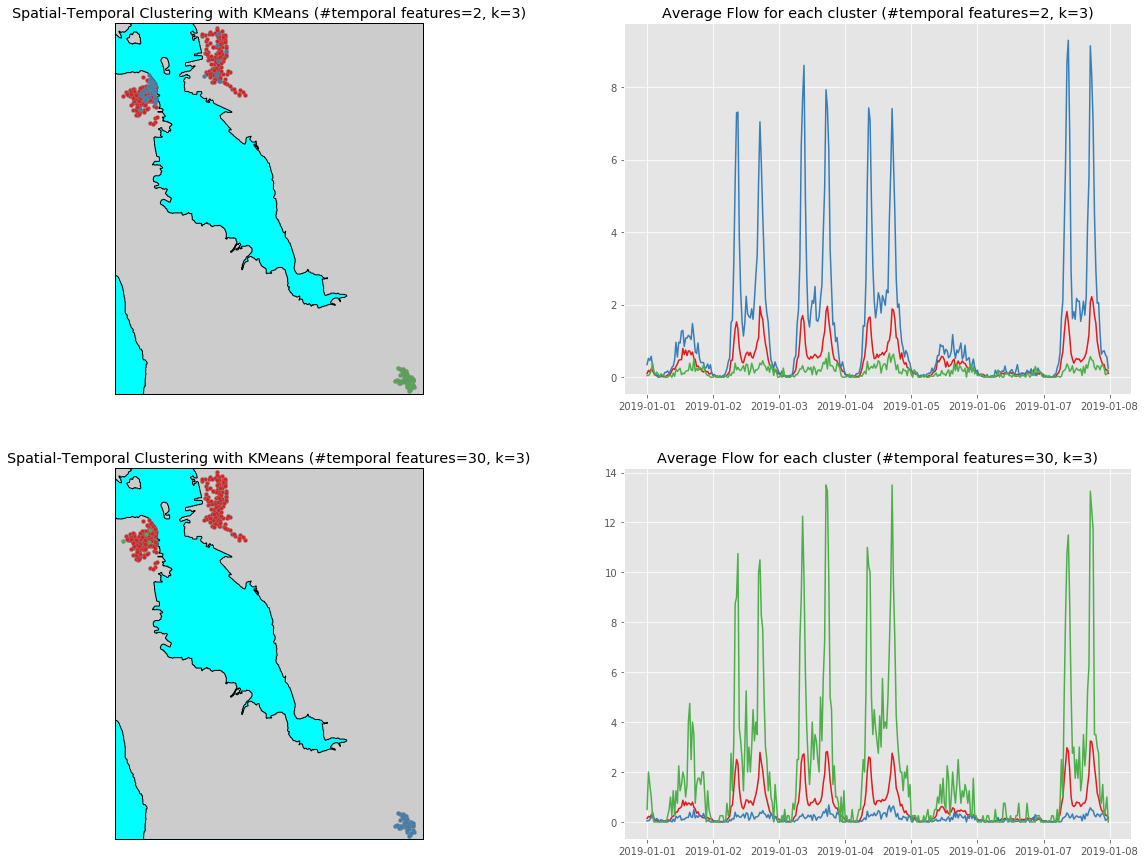

In [58]:
k = 3
n_components = [2, 30]
Xs = [combine_spatial_temporal(X, i) for i in n_components]
kmean = [KMeans(n_clusters=k).fit(data) for data in Xs]
plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_all)